This notebook shows two methods of discretization: Tauchen and Rowuenhurst.
Two functions below can be easily moved to a .jl file containing a module.

In [196]:
using Distributions, Statistics, StatsBase, Random
using Plots


In [197]:
# code for Rouwenhurst is very closely based on Arshia Hashemi's file rouwenhorst_discretization.jl
# available at https://github.com/ArshiaHashemi/Heterogeneous-Agent-Macroeconomics-in-Julia/blob/main/code/miscellaneous/rouwenhorst_discretization.jl

In [198]:

struct rouwenhurst
    # Define output
    y::Vector{Float64} # Grid for income
    P::Matrix{Float64} # Transition probability matrix
    π_vec::Vector{Float64} # Stationary probability mass function
    # Define function
    # this is a so called "inner constructor method"
    function rouwenhurst(n, μ, ρ, σ)
        # Transitition matrix parameter
        p = (1 + ρ) / 2
        # Width parameter
        ψ = sqrt((n - 1) * σ^2 / (1 - ρ^2))
        # Grid for income (before normalization)
        y = collect(range((μ - ψ), stop = (μ + ψ), length = n))
        # Transition probability matrix for π=2
        P_temp = [p (1-p); (1-p) p]
        # Two cases for n (do not do anything if n = 2, do things if n > 2)
        if n == 2
            P = P_temp
        elseif n > 2
            for i = 1:(n-2)
                # (n-1) vector of zeros
                zeros_vec = zeros(size(P_temp, 2))
                # Update transititon probability matrix
                P_temp =
                    (p * [P_temp zeros_vec; zeros_vec' 0]) +
                    ((1 - p) * [zeros_vec P_temp; 0 zeros_vec']) +
                    ((1 - p) * [zeros_vec' 0; P_temp zeros_vec]) +
                    (p * [0 zeros_vec'; zeros_vec P_temp])
            end
            # Ensure elements in each row sum to one
            P = Matrix{Float64}(undef, n, n)
            P[1, :] = P_temp[1, :]
            P[n, :] = P_temp[n, :]
            for r = 2:(n-1)
                P[r, :] = P_temp[r, :] ./ sum(P_temp[r, :])
            end
        end
        # Stationary probability mass function
        π_vec = (ones(n) ./ n)'
        for i = 1:1000
            π_vec= π_vec * (P^i)
        end
        # Convert into a column vector
        π_vec = π_vec'
        # Return output - this "new" is special to inner constructor
        new(y, P, π_vec)
    end
end;

In [199]:
n = 5;
μ = 0;
ρ = 0.5;
σ = 0.1;
rouwenhurst_AR = rouwenhurst(n, μ, ρ, σ);

P_rouwenhurst = rouwenhurst_AR.P;
y_rouwenhurst = rouwenhurst_AR.y;
π_vec_rouwenhurst = rouwenhurst_AR.π_vec;

In [200]:
struct tauchen
    # Define output
    y::Vector{Float64} # Grid for income
    P::Matrix{Float64} # Transition probability matrix
    π_vec::Vector{Float64} # Stationary probability mass function
    # Define function
    # this is a so called "inner constructor method"

    function tauchen(n, μ, ρ, σ; κ = 3)
        mean_y = μ /(1-ρ); #mean of y
        st_dev_y=σ/sqrt(1-ρ^2); #st. dev. of y
          
        y=mean_y .+ collect(LinRange(-κ*st_dev_y,κ*st_dev_y,n));
        omega=y[2]-y[1]; #Note that all the points are equidistant by construction.
          
        yi=y*ones(1,n);
        yj=ones(n,1)*y';
        
        P_part1=cdf.(Normal(),((yj.+omega/2 .-ρ*yi).-μ)/σ);
        P_part2=cdf.(Normal(),((yj.-omega/2 .-ρ*yi).-μ)/σ);
      
        P=P_part1-P_part2;
        P[:,1]= P_part1[:,1];
        P[:,n]= 1 .- P_part2[:,n];
      
        

        # Stationary probability mass function
        π_vec = (ones(n) ./ n)'
        for i = 1:1000
            π_vec= π_vec * (P^i)
        end
        # Convert into a column vector
        π_vec = π_vec'
        # Return output - this "new" is special to inner constructor
        new(y, P, π_vec)
    end
end;

In [201]:
tauchen_AR = tauchen(n, μ, ρ, σ);

P_tauchen = tauchen_AR.P;
y_tauchen = tauchen_AR.y;
π_vec_tauchen = tauchen_AR.π_vec;

In [202]:

w_rouwenhurst = Weights(π_vec_rouwenhurst);
w_tauchen     = Weights(π_vec_tauchen);

@show var(y_rouwenhurst, w_rouwenhurst, corrected = false);
@show var(y_tauchen, w_tauchen, corrected = false);


var(y_rouwenhurst, w_rouwenhurst, corrected = false) = 0.013333333333333336
var(y_tauchen, w_tauchen, corrected = false) = 0.01660466648688108


In [203]:
function mc_sample_path(P; init = 1, sample_size = 1000)
    Random.seed!(1111); 
    @assert size(P)[1] == size(P)[2] # square required
    N = size(P)[1] # should be square

    # create vector of discrete RVs for each row
    dists = [Categorical(P[i, :]) for i in 1:N]

    # setup the simulation
    X = fill(0, sample_size) # allocate memory, or zeros(Int64, sample_size)
    X[1] = init # set the initial state

    for t in 2:sample_size
        dist = dists[X[t-1]] # get discrete RV from last state's transition distribution
        X[t] = rand(dist) # draw new value
    end
    return X
end

mc_sample_path (generic function with 1 method)

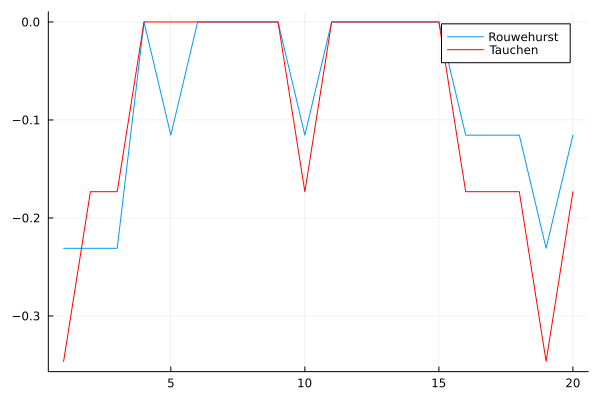

In [230]:

T = 20
path_rouwenhurst = mc_sample_path(P_rouwenhurst; init = 1, sample_size = T)
path_tauchen = mc_sample_path(P_tauchen; init = 1, sample_size = T)


y_path_rouwenhurst = y_rouwenhurst[path_rouwenhurst];
y_path_tauchen = y_tauchen[path_tauchen];


plot(y_path_rouwenhurst,label = "Rouwehurst")
plot!(y_path_tauchen,color="red",label = "Tauchen")

In [205]:
P_rouwenhurst

5×5 Matrix{Float64}:
 0.316406    0.421875  0.210938  0.046875  0.00390625
 0.105469    0.421875  0.351562  0.109375  0.0117188
 0.0351562   0.234375  0.460938  0.234375  0.0351562
 0.0117188   0.109375  0.351562  0.421875  0.105469
 0.00390625  0.046875  0.210938  0.421875  0.316406